To help gauge the impact of Brexit, we study the US bonds market. In particular, we look at the bonds issued by US firms and the bonds issued by british firms in the US markets, i.e. the so-called Yankee bonds. Bonds carry investors’ expectations. By comparing bond yields by American and British firms before and after Brexit, we can have a quantitative estimate of the Brexit effects on business and cost of debt finance. Since bonds have different maturities ranging from 1 year to 50 years even 100 years, a closer look at the bonds market not only shows the Brexit effect, but also reveals how such effect evolves over time.

The last two graphs illustrate the impact of Brexit on the yields of bonds issued by British Firms in the US market.


In [32]:
import pandas as pd
import numpy as np
import wrds
from pandas.tseries.offsets import MonthEnd
from dateutil import parser
import time
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta

In [2]:
bprice=pd.read_csv('brexit1019.csv')


In [3]:
filt1=bprice['country_domicile']=='GBR'
filt2=~bprice['yld_pt'].isna()
filt3=bprice['country_domicile']=='USA'

In [4]:
# make sure yankee debt is defined correctly
yankeeN=bprice['yankee']=='N'
yankeeY=bprice['yankee']=='Y'

bprice=bprice[ (yankeeN & filt3) | (yankeeY & filt1)  ]
bprice.reset_index(inplace=True)

In [5]:
# make sure bond_type is correct
# 
droplist=['TPCS', 'ABS', 'CPAS', 'PSTK', 'ADEB','FGOV', 'CCUR', 'AMTN', 'ASPZ']
keeplist=~bprice['bond_type'].isin(droplist)
bprice=bprice[keeplist]

In [7]:
bprice['maturity']=pd.to_datetime(bprice['maturity'], format="%Y-%m-%d")

In [8]:
bprice['trade_date']=pd.to_datetime(bprice['trade_date'], format="%Y-%m-%d")

In [10]:
bprice['ttm']=(bprice['maturity'].sub(bprice['trade_date']).dt.days.div(365).round(4))


In [11]:
bins=[0.0, 5.0, 100.0]
labels=['short', 'long']
bprice['maturity2']=pd.cut(bprice['ttm'], bins=bins, labels=labels)

In [13]:
# get the index of top1% USA yields
winsor_ind=bprice.loc[bprice['country_domicile']=='USA', 'yld_pt'].nlargest(219).index.tolist()+bprice.loc[bprice['country_domicile']=='GBR', 'yld_pt'].nlargest(42).index.tolist()


In [14]:
bprice.drop(index=winsor_ind, inplace=True)

In [16]:
group=bprice.groupby(['rating_type', 'rating'])


In [17]:
# consolidate rating using NAIC rating table
# https://www.naic.org/documents/svo_naic_aro.pdf

naic=pd.read_csv('naic.csv', dtype={'naic': 'int64'})

In [18]:
# merge rating from naic
bprice=bprice.merge(naic, how='left', left_on=['rating_type', 'rating'], right_on=['rating_type', 'rating'])

In [19]:
bpriceRating= bprice.drop(index=bprice['NAIC'].isna().index[bprice['NAIC'].isna()])

In [20]:
bpriceRating['NAIC']=bpriceRating['NAIC'].astype('int64')

In [21]:
bpriceRating.drop(columns=['index', 'Unnamed: 0'], inplace=True)
bpriceRating.head()

,cusip_id,trade_date,yld_pt,rptd_pr,ascii_rptd_vol_tx,rptg_party_type,trc_st,rn,complete_cusip,issuer_id,...,rating_type,rating_date,rating,rating_status,rating_status_date,investment_grade,brexit,ttm,maturity2,NAIC
0,00077TAA2,2010-03-24,7.638551,100.900,5MM+,NaN,T,1,00077TAA2,40263.0,...,MR,2010-02-05,A3,WNEG,NaN,NaN,False,13.1507,long,1
1,00077TAA2,2010-07-06,6.954492,106.673,100000,NaN,T,1,00077TAA2,40263.0,...,MR,2010-02-05,A3,WNEG,NaN,NaN,False,12.8658,long,1
2,00077TAA2,2010-08-27,5.757772,117.766,25000,NaN,T,1,00077TAA2,40263.0,...,FR,2010-07-14,A+,Off,NaN,NaN,False,12.7233,long,1
3,00077TAA2,2010-09-14,6.659145,109.220,41000,NaN,T,1,00077TAA2,40263.0,...,FR,2010-07-14,A+,Off,NaN,NaN,False,12.6740,long,1
4,00077TAA2,2010-10-14,6.503227,110.589,5000,NaN,T,1,00077TAA2,40263.0,...,FR,2010-07-14,A+,Off,NaN,NaN,False,12.5918,long,1


In [22]:
bpriceRating['issuer_id']=bpriceRating['issuer_id'].astype('int64')

In [23]:
# time fixed effect at year level
bpriceRating['year']=bpriceRating['trade_date'].dt.year

In [24]:
bpriceRating.rename(columns={'country_domicile': "country"}, inplace=True)

In [25]:
bpriceRating=pd.get_dummies(bpriceRating, columns=['country'], prefix=['country'])
bpriceRating.drop(columns=['country_USA'], inplace=True)

In [26]:
bpriceRating['cusip_id']=pd.Categorical(bpriceRating['cusip_id'])
bpriceRating['issuer_id']=pd.Categorical(bpriceRating['issuer_id'])
bpriceRating['month']=bpriceRating['trade_date']+MonthEnd(0)

In [27]:
bpriceRating['quarter']=pd.to_datetime( {'year': bpriceRating['trade_date'].dt.year, 
                                         'month': list(map(np.ceil, bpriceRating['trade_date'].dt.month.values/3)),
                                         'day': [1]*len(bpriceRating['trade_date'].dt.year) } )
group=bpriceRating.groupby(by=['quarter', 'country_GBR', 'maturity2'])['yld_pt'].mean().reset_index()

group=group[group['quarter']>='2015-01-01'].groupby(by=['country_GBR', 'maturity2'])


## We can see upon Brexit, the yield difference between UK and USA patently shrink for short-term bonds (< 5 years)

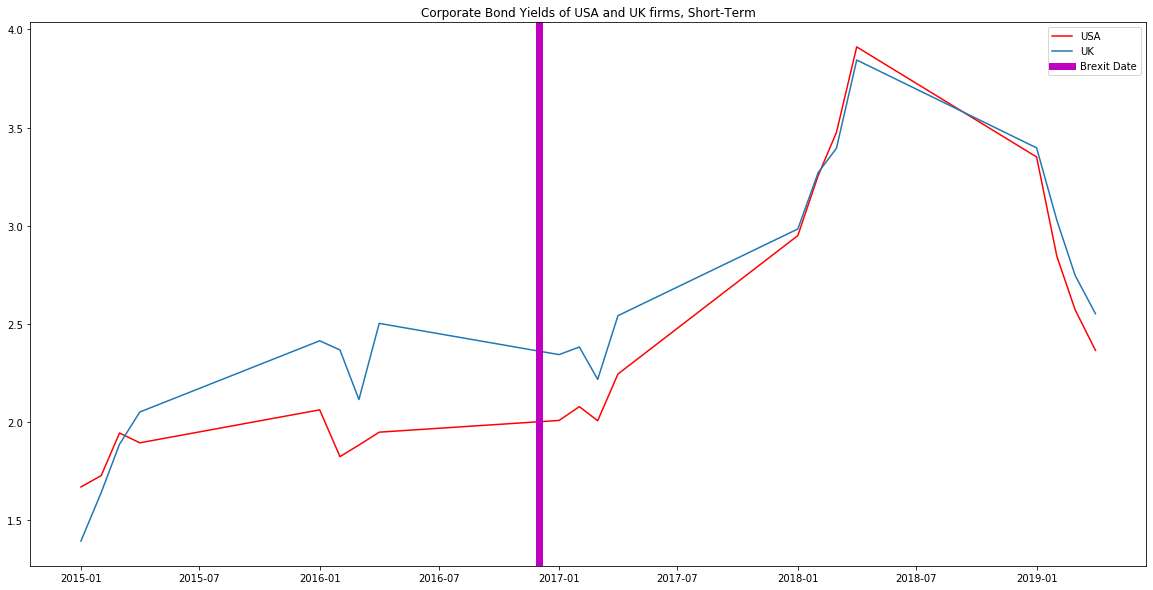

In [29]:


fig, ax = plt.subplots(figsize=(20,10))

ax.plot(group['quarter'].get_group((0, 'short')), group['yld_pt'].get_group((0, 'short')), color='r', label='USA')
ax.plot(group['quarter'].get_group((1, 'short')), group['yld_pt'].get_group((1, 'short')), label='UK')

ax.axvline(pd.to_datetime('2016-12-01',format="%Y-%m-%d"), 0 , 1, label='Brexit Date', linewidth=7.0, color='m')

ax.set_title('Corporate Bond Yields of USA and UK firms, Short-Term')
ax.legend()

## The similar pattern holders for long-term bonds as well.

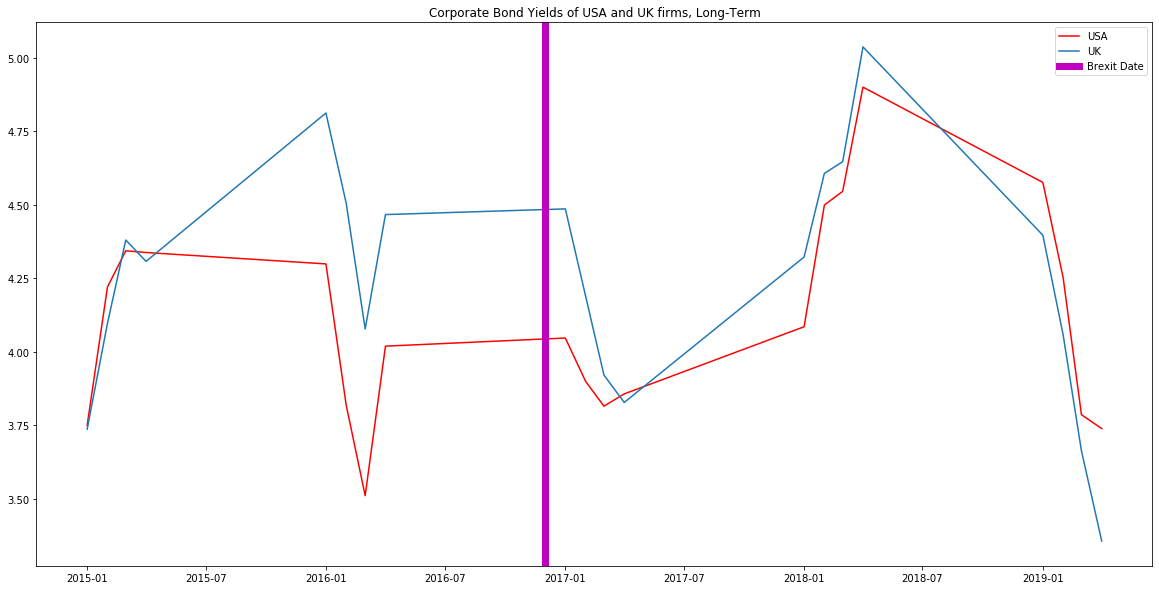

In [31]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(group['quarter'].get_group((0, 'long')), group['yld_pt'].get_group((0, 'long')), color='r', label='USA')



ax.plot(group['quarter'].get_group((1, 'long')), group['yld_pt'].get_group((1, 'long')), label='UK')
ax.axvline(pd.to_datetime('2016-12-01',format="%Y-%m-%d"), 0 , 1, label='Brexit Date', linewidth=7.0, color='m')
ax.set_title('Corporate Bond Yields of USA and UK firms, Long-Term')
ax.legend()